# VIIRS and World Population Example

## 1. VIIRS in ModelofModel

### 1.1 VIIRS Processing Steps
1. Download and generate the mosaiced images: VIIRS_1day_compositeyyyymmdd_flood.tiff, VIIRS_5day_compositeyyyymmdd_flood.tiff
2. Count the water/flood area for each watershed  
>**pfaf_id**: Global watershed ID  
>**onedayFlood_Area_km**: Area of watershed in square kilometer unit that is flooded based on one day observed data  
>**onedayperc_Area**: Percentage area of the watershed that gets flooded based on one day observed data  
>**fivedayFlood_Area_km**: Area of watershed in square kilometer unit that is flooded based on five day composite observed data with cloud shadow masking applied  
>**fivedayperc_Area**: Percentage area of the watershed that gets flooded based on five day composite observed data with cloud shadow masking applied  
3. Caculated VIIRSTotal_Score for each watershed
>**VIIRS_area_1day_score**: Score for onedayFlood_Area_km    
>**VIIRS_percarea_1day_score**: Score for onedayperc_Area    
>**VIIRS_area_5day_score**: Score for fivedayFlood_Area_km    
>**VIIRS_percarea_5day_score**: Score for fivedayperc_Area    
>**VIIRSTotal_Score**: Summation of all the scores 
4. Integrate **VIIRSTotal_Score** into Flood Severity estimation

All MoM outputs: **[MoMProduction Testing Server](https://js-170-28.jetstream-cloud.org/ModelofModels/)**

### 1.2 Example of VIIRS in Flood warning
Final_Attributes_2022061818HWRF+MOM+DFO+VIIRSUpdated_PDC produces 723 flood warning out of the toal 13602 watesheds processed. Close to 1/3 of the warnings have high VIIRSTotal_Score (>80), and most of them are in high latitude regions or coastlines.

In [1]:
import os,sys
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
# increase plot size
plt.rcParams["figure.figsize"] = (18,9)
plt.rcParams.update({'font.size': 18})
# load world data as the background
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# base = world.plot(color='white', edgecolor='black');

In [3]:
# load a sample MoM output
momfinal_geojson = "Final_Attributes_2022061818HWRF+MOM+DFO+VIIRSUpdated_PDC.geojson"
momfinal = gpd.read_file(momfinal_geojson)

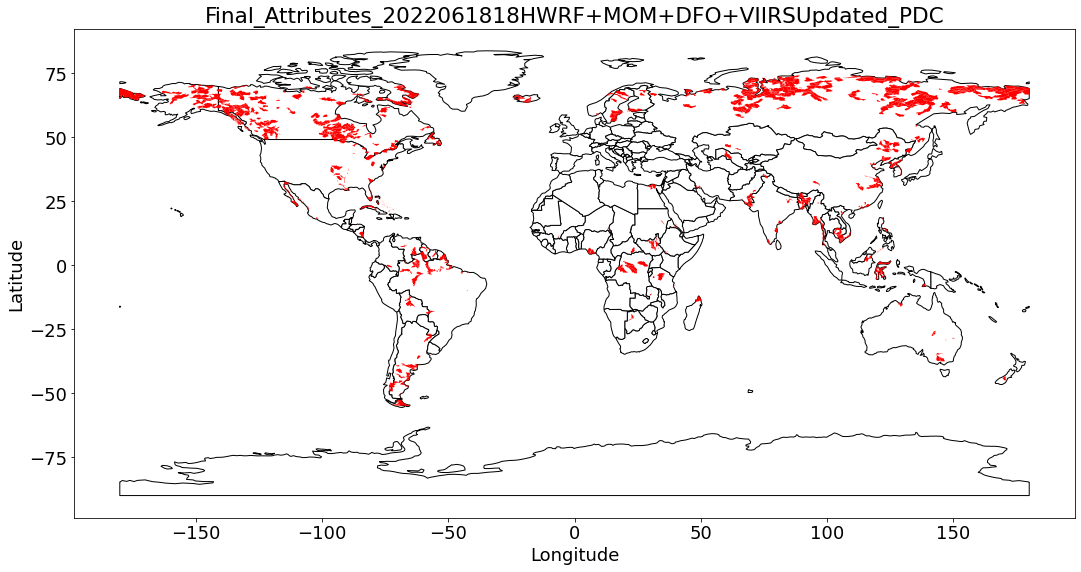

In [4]:
# plot MoM Warnings
fig,ax = plt.subplots()
ax.set(xlabel='Longitude',ylabel='Latitude',title = momfinal_geojson.split(".")[0])
base = world.plot(ax=ax,color='white', edgecolor='black');
mom_plt = momfinal.plot(ax=base, color='red');


array([<AxesSubplot:title={'center':'VIIRSTotal_Score'}, xlabel='Value (0-100)', ylabel='Count'>],
      dtype=object)

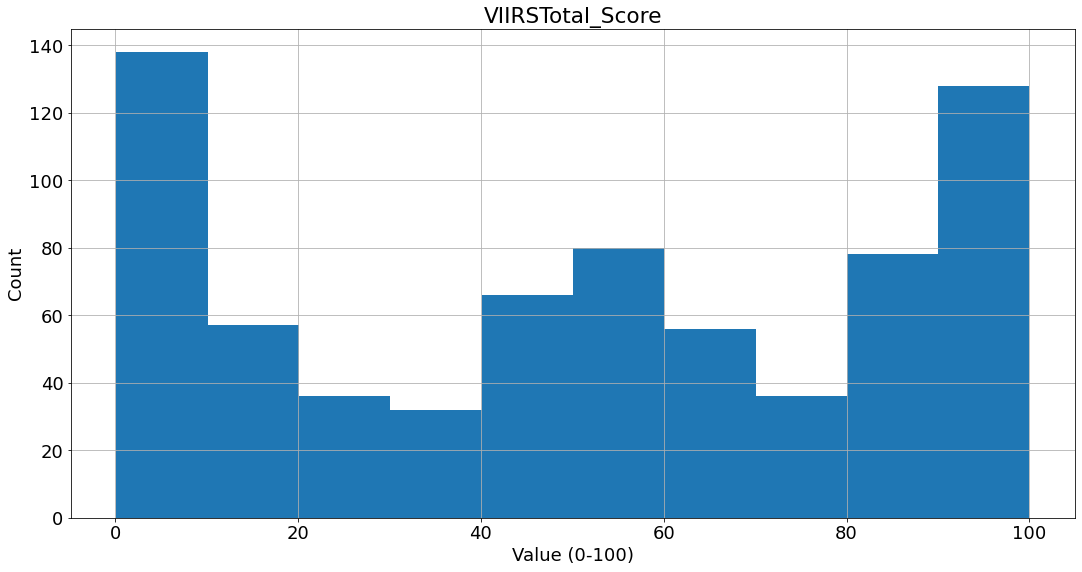

In [5]:
fig,ax = plt.subplots()
ax.set(xlabel='Value (0-100)',ylabel='Count')
momfinal.hist(column='VIIRSTotal_Score',ax=ax)

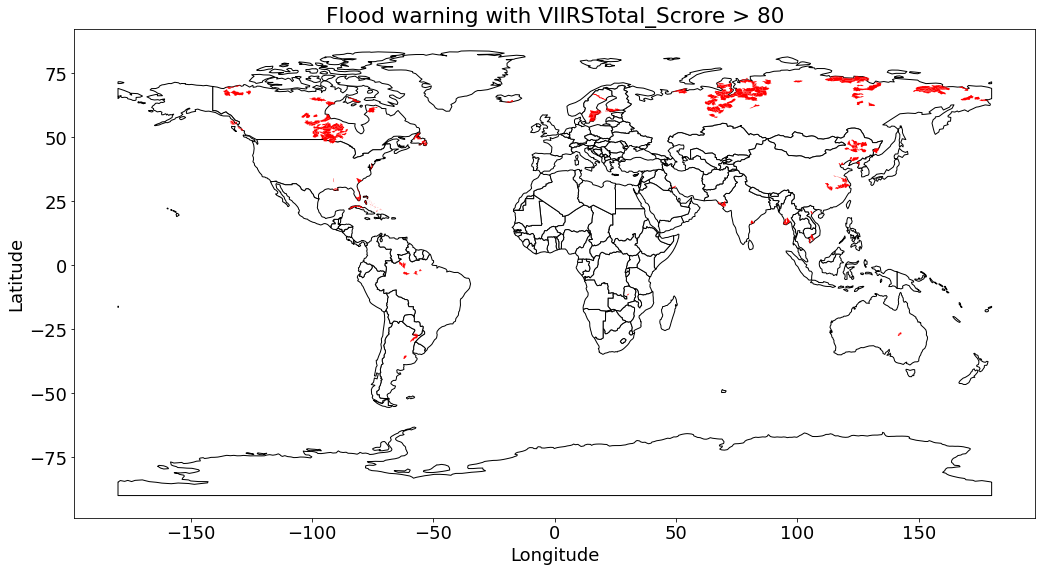

In [6]:
viirs_highscore = momfinal.loc[momfinal['VIIRSTotal_Score'] > 80]
# plot MoM Warnings
fig,ax = plt.subplots()
ax.set(xlabel='Longitude',ylabel='Latitude',title = "Flood warning with VIIRSTotal_Scrore > 80")
base = world.plot(ax=ax,color='white', edgecolor='black');
viirs_highscore.plot(ax=base, color='red');

## 2. VIIRS and Population Data
We use [Constrained individual countries 2020 (100m resolution](https://hub.worldpop.org/geodata/listing?id=78) in this example, more information on [Population Counting Methods](https://www.worldpop.org/methods/populations/).   
Samples: [United States Popluation 2020](https://hub.worldpop.org/geodata/summary?id=49727)  
Note: due to the high resolution, the population geotiffs are highly compressed and slow to work with, we can do a preprocessing to generate the much smaller geotiffs for individual watersheds. 

### 2.1 Sample one: Florida, Miami, pfaf_id = 732572
#### 2.1.1 Clip images with the watershed

In [7]:
pfaf_id = 732572

In [8]:
watershed = momfinal.loc[momfinal['pfaf_id'] == pfaf_id]

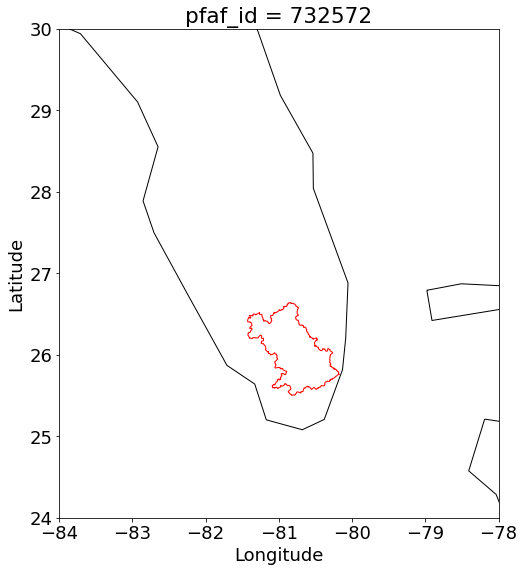

In [9]:
fig,ax = plt.subplots()
ax.set(xlabel='Longitude',ylabel='Latitude',title = "pfaf_id = " + str(pfaf_id));
base = world.plot(ax=ax,color='white', edgecolor='black');
watershed.plot(ax=base,color='white',edgecolor='red');
plt.xlim([-84,-78]);
plt.ylim([24,30])
plt.show()

In [10]:
# clip raster files with watershed
# generate a json mask
import json
import rasterio
from rasterio.mask import mask
the_mask = json.loads(gpd.GeoSeries(watershed['geometry']).to_json())

In [11]:
# raster mask function
def clipbymask(tiffimage, mask_json,clippedimage):
    """ clip a [tiffimage] by [mask_josn], saved as [clippedimage]"""
    
    with rasterio.open(tiffimage) as src:
        try:
            out_image, out_transform = mask(src, [mask_json['features'][0]['geometry']], crop=True)
            out_meta = src.meta.copy()
        except ValueError as e:
            #'Input shapes do not overlap raster.'
            src = None
            area=0
            # return empty dataframe
            return area
    out_meta.update({"height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    with rasterio.open(clippedimage, "w", **out_meta) as dest:
        dest.write(out_image)

In [12]:
data_date = '20220617'
tiffs = [["VIIRS_1day_composite20220617_flood.tiff",f"1day_{data_date}_{pfaf_id}.tiff"],
         ["VIIRS_5day_composite20220617_flood.tiff",f"5day_{data_date}_{pfaf_id}.tiff"],
         ["usa_ppp_2020_constrained.tif",f"pop_{pfaf_id}.tiff"]]

In [13]:
for entry in tiffs:
    inimage,outimage = entry
    clipbymask(inimage,the_mask,outimage)

In [14]:
from rasterio.plot import show
#load rasters
rasters = []
for entry in tiffs:
    tiff = entry[1]
    raster = rasterio.open(entry[1])
    rasters.append([tiff,raster])

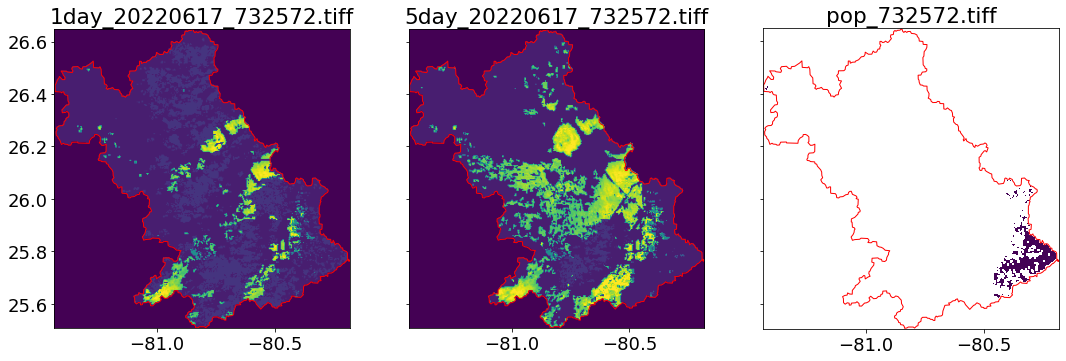

In [15]:
# Initialize subplots
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, sharey=True)

# Plot Red, Green and Blue (rgb)
show((rasters[0][1]),  ax=ax1)
show((rasters[1][1]),  ax=ax2)
show((rasters[2][1]),  ax=ax3)
watershed.plot(ax=ax1,facecolor='none',edgecolor='red');
watershed.plot(ax=ax2,facecolor='none',edgecolor='red');
watershed.plot(ax=ax3,facecolor='none',edgecolor='red');
# Add titles
ax1.set_title(rasters[0][0])
ax2.set_title(rasters[1][0])
ax3.set_title(rasters[2][0])
plt.show()

#### 2.1.2 Counting Population data against water/flood
1. Resize the clipped VIIRS image as the same size as the clipped population image  
2. Generate a binary image (1 -- water/flood, 0 -- others)
3. Generate a new image by multiplying the population image with the binary image
4. Count the population impacted by the water/flood

In [16]:
# need upSampling VIIRS image as the same size of pop tiff
pop_image = f"pop_{pfaf_id}.tiff"
raster = rasterio.open(entry[1])
ysize,xsize = raster.shape

In [17]:
# gdal_calc.py -A 1day_20220617_732572.tiff --calc="(A<=140)*0 + logical_and(A>140, A<201)*1 + (A>=201)*0" --outfile 1day_binary.tiff
# gdal_calc.py -A 5day_20220617_732572.tiff --calc="(A<=140)*0 + logical_and(A>140, A<201)*1 + (A>=201)*0" --outfile 5day_binary.tiff
# gdal_calc.py -A 1day_binary.tiff -B pop_732572.tiff --calc="A*B" --outfile 1day_pop_count.tiff
# gdal_translate -of GTiff  -outsize 1502 1368 1day_binary.tiff 1day_binary_resize.tiff

def generate_popcountimage(viirs_image,pop_image,popcount_image,image_size):
    """ generate pop counting image with map algebra"""
    # generate binary image
    
    binary_image = viirs_image.replace(".","_binary.")
    cmd = f'gdal_calc.py -A {viirs_image} --calc="(A<=140)*0 + logical_and(A>140, A<201)*1 + (A>=201)*0" --outfile {binary_image} > /dev/null'
    os.system(cmd)
    # resize binary image
    resize_image = binary_image.replace(".","_resize.")
    xsize, ysize = image_size
    cmd = f'gdal_translate -of GTiff -outsize {xsize} {ysize} {binary_image} {resize_image} > /dev/null'
    os.system(cmd)
    # calculate A*B
    cmd = f'gdal_calc.py -A {resize_image} -B {pop_image} --calc="A*B" --outfile {popcount_image} > /dev/null'
    os.system(cmd)
    

In [18]:
# process 1day image
viirs_image = f"1day_{data_date}_{pfaf_id}.tiff"
count_image_1day = "pop_"+viirs_image
generate_popcountimage(viirs_image,pop_image,count_image_1day,[xsize,ysize])

In [19]:
# process 5day image
viirs_image = f"5day_{data_date}_{pfaf_id}.tiff"
count_image_5day = "pop_"+viirs_image
generate_popcountimage(viirs_image,pop_image,count_image_5day,[xsize,ysize])

In [20]:
import numpy as np
# count the population
for img in [pop_image,count_image_1day,count_image_5day]:
    src = rasterio.open(img)
    data = src.read(1)
    print(img, "total population count")
    print(int(np.sum(data,where=(data != src.nodata))))

pop_732572.tiff total population count
1621761
pop_1day_20220617_732572.tiff total population count
4244
pop_5day_20220617_732572.tiff total population count
10198


### 2.1.2 Flood or not?
#### In this watershed, the max population directly impacted is **10,198** out of **1,621,761** (0.63%).

## 2.2 Sample two: South Sudan, Jungoli, pfaf_id = 172704

### 2.2.1 Data Processing

In [21]:
pfaf_id = 172704
watershed = momfinal.loc[momfinal['pfaf_id'] == pfaf_id]
the_mask = json.loads(gpd.GeoSeries(watershed['geometry']).to_json())
tiffs = [["VIIRS_1day_composite20220617_flood.tiff",f"1day_{data_date}_{pfaf_id}.tiff"],
         ["VIIRS_5day_composite20220617_flood.tiff",f"5day_{data_date}_{pfaf_id}.tiff"],
         ["ssd_ppp_2020_constrained.tif",f"pop_{pfaf_id}.tiff"]]

In [22]:
for entry in tiffs:
    inimage,outimage = entry
    clipbymask(inimage,the_mask,outimage)

In [23]:
from rasterio.plot import show
#load rasters
rasters = []
for entry in tiffs:
    tiff = entry[1]
    raster = rasterio.open(entry[1])
    rasters.append([tiff,raster])

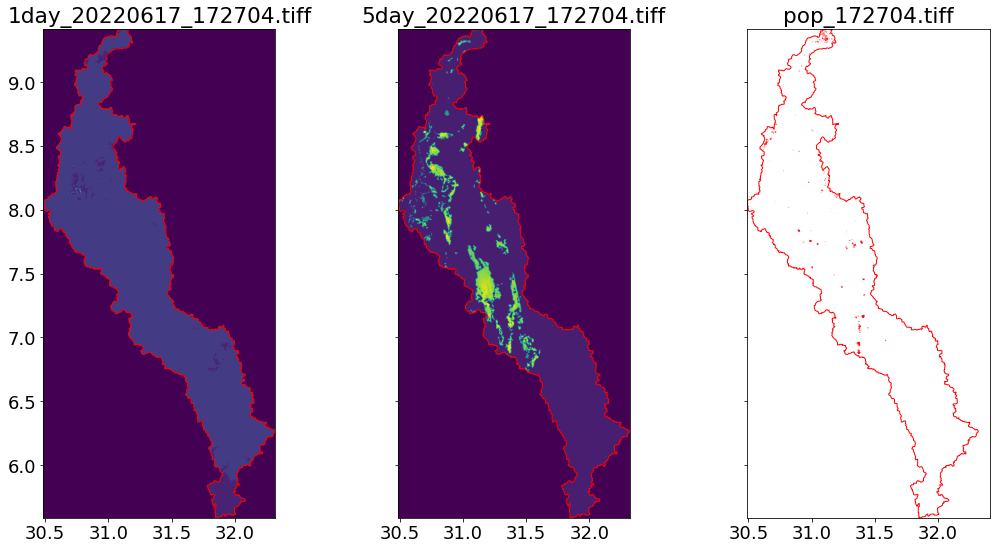

In [24]:
# Initialize subplots
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, sharey=True)

# Plot Red, Green and Blue (rgb)
show((rasters[0][1]),  ax=ax1)
show((rasters[1][1]),  ax=ax2)
show((rasters[2][1]), contour=True, ax=ax3)
watershed.plot(ax=ax1,facecolor='none',edgecolor='red');
watershed.plot(ax=ax2,facecolor='none',edgecolor='red');
watershed.plot(ax=ax3,facecolor='none',edgecolor='red');
# Add titles
ax1.set_title(rasters[0][0])
ax2.set_title(rasters[1][0])
ax3.set_title(rasters[2][0])
plt.show()

In [25]:
# need upSampling VIIRS image as the same size of pop tiff
pop_image = f"pop_{pfaf_id}.tiff"
raster = rasterio.open(entry[1])
ysize,xsize = raster.shape

In [26]:
# process 1day image
viirs_image = f"1day_{data_date}_{pfaf_id}.tiff"
count_image_1day = "pop_"+viirs_image
generate_popcountimage(viirs_image,pop_image,count_image_1day,[xsize,ysize])
# process 5day image
viirs_image = f"5day_{data_date}_{pfaf_id}.tiff"
count_image_5day = "pop_"+viirs_image
generate_popcountimage(viirs_image,pop_image,count_image_5day,[xsize,ysize])

In [27]:
# count the population
for img in [pop_image,count_image_1day,count_image_5day]:
    src = rasterio.open(img)
    data = src.read(1)
    print(img, "total population count")
    print(int(np.sum(data,where=(data != src.nodata))))

pop_172704.tiff total population count
404857
pop_1day_20220617_172704.tiff total population count
0
pop_5day_20220617_172704.tiff total population count
128833


### 2.2.2 Flood or not?
#### In this watershed, the max population directly impacted is **128,833** out of **404,857** (31.8%).